Импортируем необходимые библиотеки, и делаем некоторые предустановки.

In [ ]:
import pandas as pd
from IPython.core.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Javascript

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

## Общий обзор
Читаем файл, выводим датасет.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/sf/stud_math.csv')
df.head(10)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


У нас в распоряжении данные о 395 учениках. С первого взгляда видим, что некоторые поля содержат пустые значения.
И кажется еще кое-что.
Посмотрим информацию о колонках.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Приведем все названия колонок в нижний регистр.

In [ ]:
df.columns = map(str.lower, df.columns)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   pstatus              350 non-null    object 
 6   medu                 392 non-null    float64
 7   fedu                 371 non-null    float64
 8   mjob                 376 non-null    object 
 9   fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Наблюдается два интересных момента.
1. Колонок в нашем датасете 30, в то время как в описании датасета - 29. Видим отсутствующую в описании колонку "studytime, granular", в которой 388 ненулевых значений, так же как и в колонке "studytime". Совпадают ли данные в этих колонках? Выясним позже а пока возьмем на заметку.
2. Не все колонки числового типа отражают абсолютный колчиственный показатель. Например, такие колонки как Medu, Fedu - упрощенное представление об уровне образования.

## Рассмотрим все столбцы

Составим словарь допустимых значений для "номинативных" столбцов. Он понадобится нам для отображения информации на графиках.

"Номинативных" написано в кавычках, потому что, как упомяналось ранее, некторые числовые столбцы не отражают количественный показатель, и такие столбцы в принципе можно считать номинативными

In [ ]:
rules = {
    "sex": {
        "title": "пол",
        "values": {
          "F": 'девушки',
          "M": "юноши"   
        }
    },
    "address": {
        "title": "адрес",
        "values": {
          "U": "город",
          "R": "за городом"   
        }
    },
    "famsize": {
        "title": "размер семьи",
        "values": {
          "LE3": "<= 3",
          "GT3": "> 3"
        }
    },
    "pstatus": {
        "title": "родители вместе?",
        "values": {
          "T": "вместе",
          "A": "раздельно"
        }
    },
    "medu": {
        "title": "образование матери",
        "values": {
          0: "нет",
          1: "4 кл",
          2: "5-9 кл",
          3: "11 кл или ср.сп.",
          4: "высшее",
        }
    },
    "fedu": {
        "title": "образование отца",
        "values": {
          0: "нет",
          1: "4 кл",
          2: "5-9 кл",
          3: "11 кл или ср.сп.",
          4: "высшее",
        }
    },
    "fjob": {
        "title": "работа отца",
        "values": {
          "teacher": "учитель",
          "health": "здравохранение",
          "services": "гос.служба",
          "at_home": "не работает",
          "other": "другое",
        }
    },
    "mjob": {
        "title": "работа матери",
        "values": {
          "teacher": "учитель",
          "health": "здравохранение",
          "services": "гос.служба",
          "at_home": "не работает",
          "other": "другое",
        }
    },
    "reason": {
        "title": "причина выбора школы",
        "values": {
          "home": "близость к дому",
          "reputation": "репутация",
          "course": "об. программа",
          "other": "другое",
        }
    },
    "guardian": {
        "title": "опекун",
        "values": {
          "mother": "мать",
          "father": "отец",
          "other": "другое",
        }
    },
    "traveltime": {
        "title": "время до школы (мин)",
        "values": {
          1: "< 15",
          2: "15-30",
          3: "30-60",
          4: "> 60",
        }
    },
    "studytime": {
        "title": "время учебы вне школы (ч)",
        "values": {
          1: "< 2",
          2: "2-5",
          3: "5-10",
          4: "> 10",
        }
    },
    "failures": {
        "title": "внеучебные неудачи",
        "values": {
          1: "1",
          2: "2",
          3: "3",
          0: "другое",}
    },
    "schoolsup": {
        "title": "доп. обр. поддержка",
        "values": {
          "yes": "да",
          "no": "нет"
        }
    },
    "famsup": {
        "title": "семейная обр. поддержка",
        "values": {
          "yes": "да",
          "no": "нет"
        }
    },
    "paid": {
        "title": "доп. платная математика",
        "values": {
          "yes": "да",
          "no": "нет"
        }
    },
    "activities": {
        "title": "доп. внеучебные занятия",
        "values": {
          "yes": "да",
          "no": "нет"
        }
    },
    "nursery": {
        "title": "дет. сад",
        "values": {
          "yes": "да",
          "no": "нет"
        }
    },
    "higher": {
        "title": "вышку хочет?",
        "values": {
          "yes": "да",
          "no": "нет"
        }
    },
    "internet": {
        "title": "интернет есть?",
        "values": {
          "yes": "да",
          "no": "нет"
        }
    },
    "romantic": {
        "title": "отношения",
        "values": {
          "yes": "да",
          "no": "нет"
        }
    },
    "famrel": {
        "title": "семейные отношения",
        "values": {
          1: "ужасные",
          2: "плохие",
          3: "норм",
          4: "хорошие",
          5: "прекрасные",
        }
    },
    "freetime": {
        "title": "свобода",
        "values": {
          1: "оч мало",
          2: "мало",
          3: "норм",
          4: "много",
          5: "оч много",
        }
    },
    "goout": {
        "title": "время с друзьями",
        "values": {
          1: "оч мало",
          2: "мало",
          3: "норм",
          4: "много",
          5: "оч много",
        }
    },
    "health": {
        "title": "здоровье",
        "values": {
          1: "ужасное",
          2: "плохое",
          3: "норм",
          4: "хорошее",
          5: "прекрасное",
        }
    }
}

Заменим nan на 'nan' в строковых типах, чтобы отобразить их на диаграммах.

In [ ]:
for column_name in df:
  df[column_name] = df[column_name].map(lambda x: None if x != x else x)

In [ ]:
df['address'].value_counts()

U    295
R     83
Name: address, dtype: int64

Поскольку в датасете не много данных, и даже в числовых столбцах кол-во уникальных значений не сильно велико, то можно построить для всех столцов столбчатые диаграммы и посмотреть на распределение по признакам.

<IPython.core.display.Javascript object>

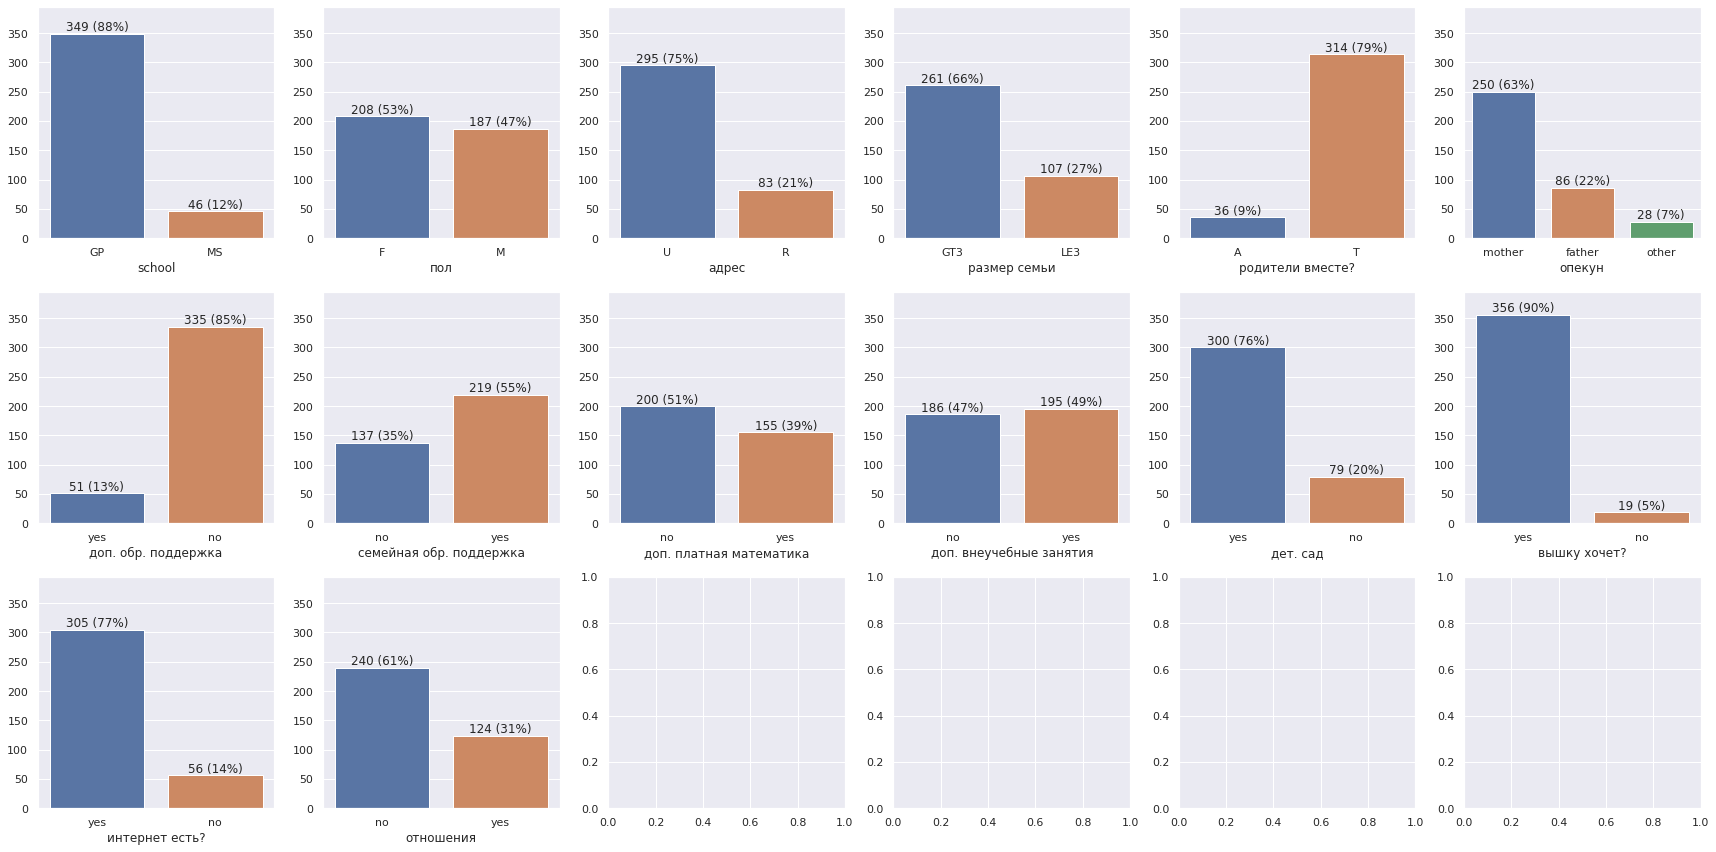

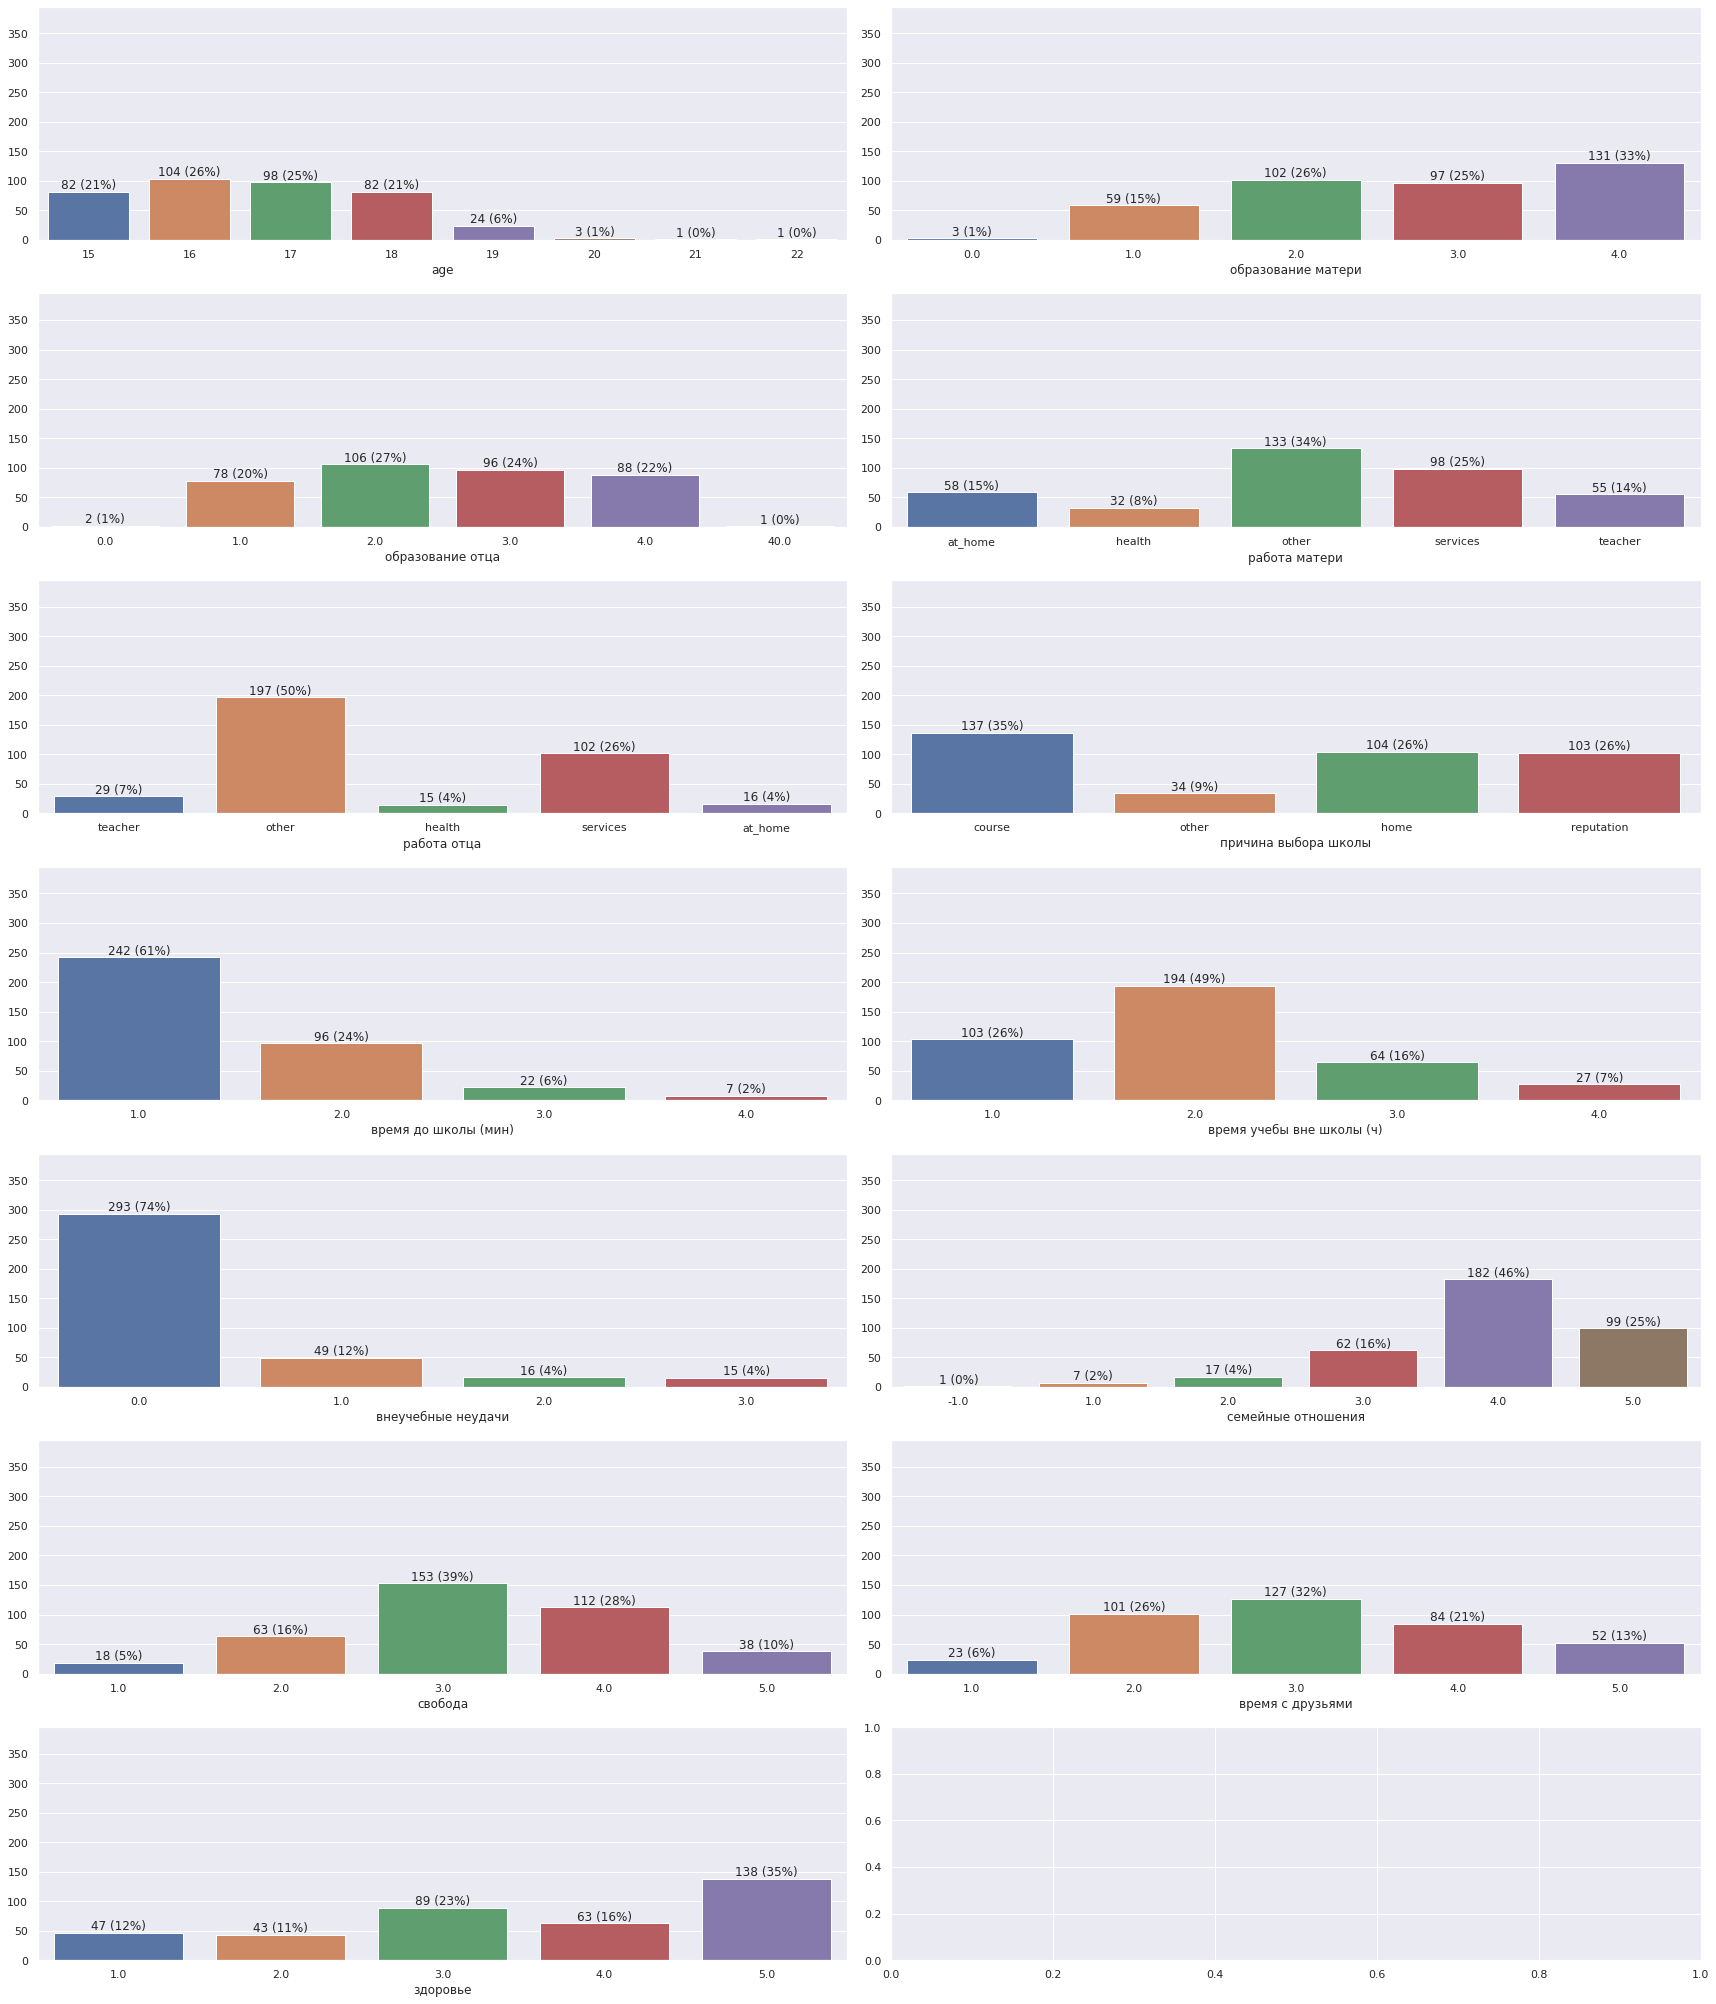

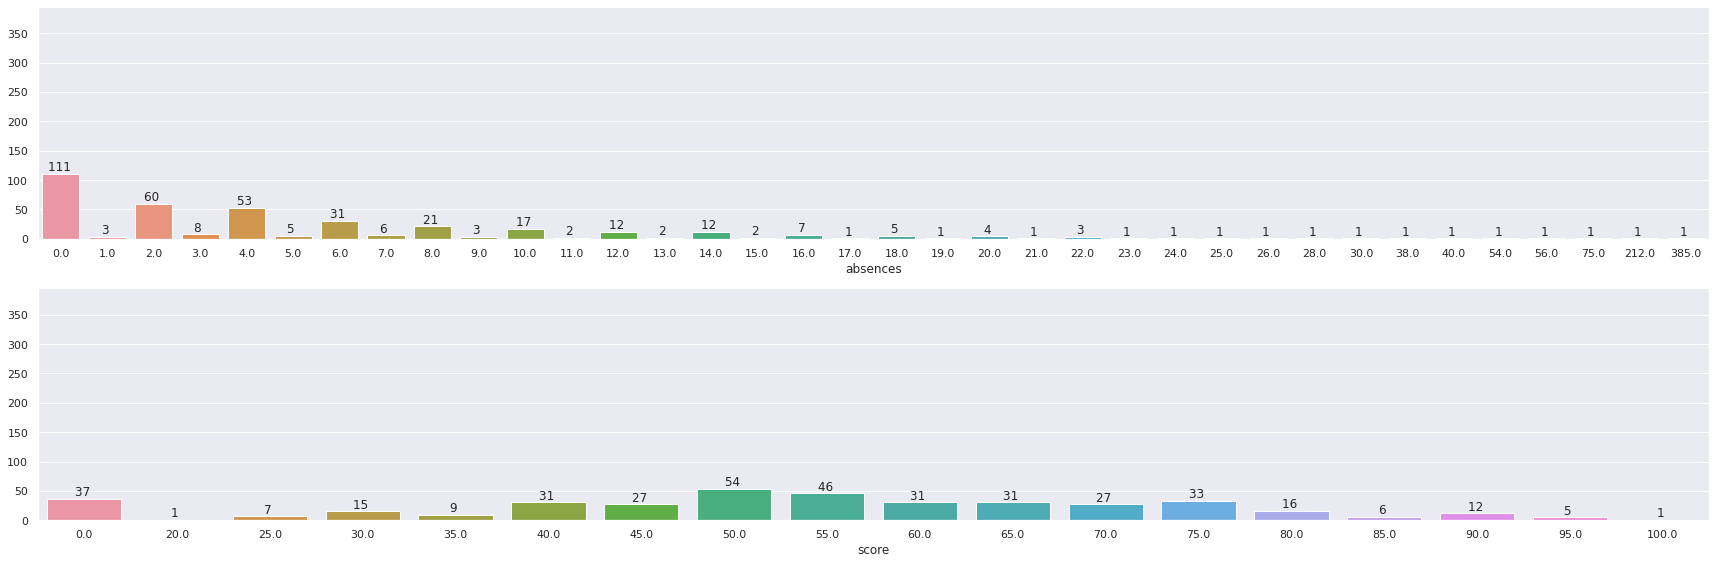

In [ ]:
def explore(df, columns, inrow = 4, percent = True):
  fig, axes = plt.subplots(
    math.ceil(len(columns)/inrow), 
    inrow, 
    figsize=(24, math.ceil(len(columns)/inrow) * 4)
  )

  for column in columns:
    if len(columns) > len(columns) / inrow:
      ax = axes[
        int(math.floor(columns.index(column) + 1) / inrow - 0.00000001),
        int(columns.index(column) % inrow)
      ]
    else:
      ax = axes[int(math.floor(columns.index(column) + 1) / inrow - 0.00000001)]

    df.sort_values(by = [column])
    countplot = sns.countplot(data = df, x = column, ax = ax)
  
    countplot.set(
      ylim=(0, len(df)),
      xlabel = rules[column]['title'] if column in list(rules.keys()) else column, 
      ylabel=''
    )
  
    for p in countplot.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        countplot.annotate(
            f'{int(y)} {f"({int(round(100*y/len(df), 0))}%)" if percent else ""}', 
            (x.mean(), y), 
            ha ='center', 
            va='bottom'
        )
  
  fig.tight_layout() 
  fig.show()

explore(df, ['school', 'sex', 'address', 'famsize', 'pstatus', 
  'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
  'higher', 'internet', 'romantic'], 6)

explore(df, ['age', 'medu', 'fedu', 'mjob', 'fjob', 'reason', 
  'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 
  'goout', 'health'], 2)

explore(df, ['absences', 'score'], 1, percent = False)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 999999})'''))